# 104人力銀行職缺－技能需求比序分析

In [12]:
from urllib.request import urlopen
import json, time, random, jieba
import requests
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import ssl
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib
#import seaborn as sns
ssl._create_default_https_context = ssl._create_unverified_context
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 100)

In [2]:
user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36"
headers = {'User-agent' : user_agent}
search_url = 'https://www.104.com.tw/jobs/search/'

In [3]:
def getJobList(job, page):
    '''
    Collecting all job posts url
    :param job: String, Specify the job title that to be searched
    :param page: Integer, How many pages of searching results to be shown
    :return: a list of searching result consists of job title and its web url
    '''
    try:
        os.mkdir('./{}'.format(job))
    except Exception as error_name:
        print(error_name)
        pass

    job_list = []
    ss = requests.session()
    total_html = ''

    # For loop is to visit multiple searching result pages
    for i in range(page):
        query_str = '''ro: 0
        kwop: 7
        keyword: {}
        jobcatExpansionType: 0
        order: 14
        asc: 0
        page: {}
        mode: s
        jobsource: 2018indexpoc'''.format(job, i + 1)

        param_data = {}
        for each_line in query_str.split('\n'):
            param_data[each_line.split(': ')[0]] = each_line.split(': ')[1]

        response = ss.get(url=search_url, params=param_data, headers=headers)
        total_html += response.text

    # Adding follow-on pages html into a big string
    soup = BeautifulSoup(total_html, 'html.parser')

    job_titles = soup.select('h2.b-tit')
    for each_job in job_titles:
        job = each_job.select('a')
        for item in job:
            url = 'https:' + item['href']
            title = item.text
            job_list.append('{}: {}'.format(title, url))

    return job_list

In [4]:
def getJobDescription(jobList):
    '''
    Extracting job description details from each recruitment post
    :param jobList: List, input a list of job research result
    :return description_dict: Dictionary, return a dictionary of jobs description {keys: [title, company, edu, skill]}
    '''
    # 104 blocking users from locating the tag by using bs4, therefore, I found that they provide a json file when execute a GET request
    # to a certain url, with headers including referer


    description_dict = {}
    index = 1
    for job in jobList:
        job_title = job.split(": ")[0]
        job_id = job.split(': ')[1].split('?')[0].split('/')[4]
        job_url = 'https://www.104.com.tw/job/ajax/content/{}'.format(job_id)
        headers = {
            "Referer": "https://www.104.com.tw/job/{}".format(job_id),
        }
        response = requests.get(url=job_url, headers=headers)
        time.sleep(random.randrange(1,3))
        job_details = json.loads(response.text)

        company_name = job_details['data']['header']['custName']
        job_content = job_details['data']['jobDetail']['jobDescription']
        specialty = job_details['data']['condition']['specialty']
        skill = job_details['data']['condition']['other']
        education = job_details['data']['condition']['edu']

        description_dict[str(index)] = {'title': job_title, 'company': company_name, 'description' : job_content, 'edu': education, 'skill': str(job_content) + str(specialty) + skill}
        index += 1

    print("Online Job searching completed")
    return description_dict

In [5]:
def saveCSV(job_dict):
    '''
    :param job_dict: Input a dictionary of job searching result
    :return: no return object, this function creates a csv file
    '''
    description = job_dict
    columns = ['No.', 'Job_Company', 'Job_Title', 'Job_Description', 'Education_level', 'Skills_Requirement']
    data = []
    for n, key in enumerate(description):
        data.append([n+1, description[key]['company'], description[key]['title'], description[key]['description'], description[key]['edu'], description[key]['skill']])
    df = pd.DataFrame(columns=columns, data=data)
    df.to_csv('./jobsearch.txt', index=True)
    print("Job searching result saved into CSV file")

In [6]:
def skillClassify(file_path):
    '''
    Segament the skills requirement.
    :param file_path: String, specify the file in which we want to classify resulting skills
    :return: no returning object, this function creates another txt file, contains skills counts.
    '''

    df = pd.read_csv(file_path)
    all_skills = df.loc[:, 'Skills_Requirement']

    skill_set = {'python', 'nosql', 'sql', 'r', 'ai', 'r語言', 'mysql', 'mongodb', '資料庫', 'javascript', '機器學習', '深度學習',
                 '資料探勘', '文字探勘', 'linux',
                 '統計學', '資料庫', '資料分析', 'sap', 'sas', 'java', 'c++', 'c#'}
    jieba.load_userdict('./mydict.txt')

    keyword_list = []
    new_columns = []

    for i in range(len(all_skills)):
        s = str(all_skills[i])
        clean = s.strip('\r\n')
        s_3 = '|'.join(jieba.cut(clean))
        keyword_list = [i for i in s_3.split('|') if len(i) > 1]

        current_set = set([i.lower() for i in keyword_list])
        new_columns.append(list(skill_set.intersection(current_set)))


    df['Skills_Requirement'] = new_columns
    df.to_csv('./job_skills.txt')
    print("Required Job skills categorized")

In [7]:
def result_plot():
    '''
    Plot out the result
    '''

    # setting Chinese font
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

    df = pd.read_csv('./job_skills.txt')
    skills_set = []
    for item in df.loc[:, 'Skills_Requirement']:
        if len(item) > 0:
            for each in (item.strip('[').strip(']').replace("'", '').replace(' ', '')).split(','):
                if len(each) > 0:
                    skills_set.append(each)
    count_result = Counter(skills_set)
    skills_dict = dict(count_result.most_common())

    skills_name = list(skills_dict.keys())
    skills_data = list(skills_dict.values())

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.barh(skills_name, skills_data)
    plt.savefig('./image/資料分析師需求技能.png')
    plt.show(block=True)

In [8]:
def execute(searching_key, searching_numb):
    '''
    main execution flow
    :param searching_key: String, searching keyword
    :param searching_numb: Integer, desired searching pages
    :return:
    '''

    searching_keyword = searching_key
    searching_pages = int(searching_numb)
    getjob = getJobList(searching_keyword, searching_pages)
    description = getJobDescription(getjob)
    saveCSV(description)
    skillClassify('./jobsearch.txt')
    result_plot()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/zm/s7_3lwv15ms47z_bwlnx1ypc0000gn/T/jieba.cache


Online Job searching completed
Job searching result saved into CSV file


Loading model cost 0.652 seconds.
Prefix dict has been built successfully.


Required Job skills categorized


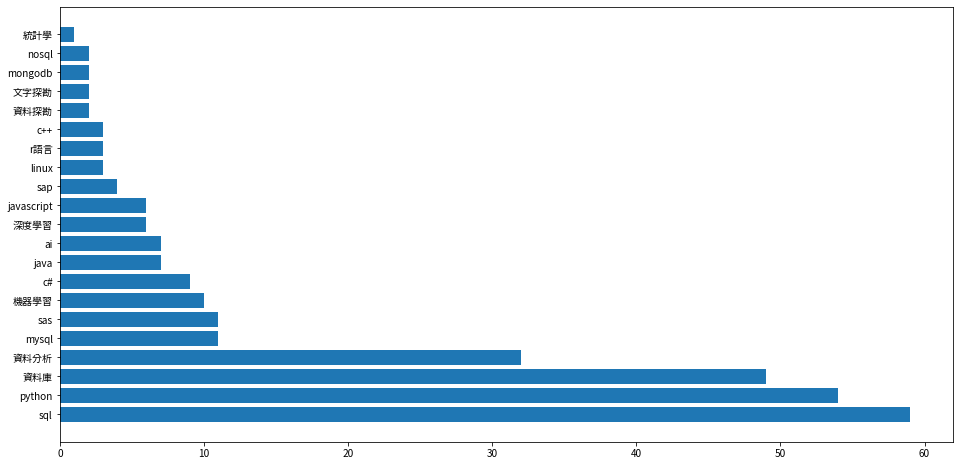

In [9]:
if __name__ == '__main__':
    result = execute('資料分析師', 5)

In [13]:
# Take a look at the recruitment description
df = pd.read_csv('./job_skills.txt')
df

,Unnamed: 0,Unnamed: 0.1,No.,Job_Company,Job_Title,Job_Description,Education_level,Skills_Requirement
0,0,0,1,台灣羅氏醫療診斷設備股份有限公司,Product Manager 產品經理 (Cardiac & Critical care),Job Summary :\nResponsible for Marketing Plann...,大學、碩士,[]
1,1,1,2,統一集團_安源資訊股份有限公司,系統設計師-數位應用開發Team,1. 協助與ibon平台既有服務維運進行整合、疏通、測試等\n2. 禮贈系統平台開發及測試\...,大學以上,['sql']
2,2,2,3,智邦科技股份有限公司,資安主管/工程師,•Managing a team of Network administrators.\n•...,大學,[]
3,3,3,4,英商克雷達投資有限公司台灣分公司,P12-數據分析師（產品部）,1. 通過專案，對產品問題進行深入分析，為產品方向、產品策略提供資料及數據支援。\n2. 統...,大學以上,"['資料探勘', 'python', 'sql', '資料分析']"
4,4,4,5,英商克雷達投資有限公司台灣分公司,SO1-資深JAVA工程師（Logistics Department）,1. 深入理解跨境業務，參與需求分析，並為服務開發提供架構設計\n2. 按技術開發規範撰寫程...,大學以上,"['java', 'sql', '資料庫', 'mysql']"
...,...,...,...,...,...,...,...,...
101,101,101,102,神基科技股份有限公司,系統整合分析師(南港)-RVSBG 商務運營發展部,1. Evaluates new technological developments an...,大學以上,"['java', 'python']"
102,102,102,103,忠欣股份有限公司,系統分析師,1.分析、設計不同系統間的資料流介接。例：電子商務系統、客戶服務管理系統、客戶關係管理系統、...,大學以上,[]
103,103,103,104,美時化學製藥股份有限公司,SAP 系統分析師 (FI and BI系統維護與開發),"1. 支援亞洲銷售和財務團隊, 改善並優化財務流程及報表 Support Asian com...",大學以上,"['sap', '資料庫', '資料分析']"
104,104,104,105,富爾特科技股份有限公司,系統分析師,1.\t二年以上網站程式開發經驗\r\n2.\t一年以上系統分析/設計經驗，具電商或電影相關...,大學,[]


## checking Chinese font for matplotlib

In [10]:
# import matplotlib.font_manager
 
# a = sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
 
# for i in a:
#     print(i)

In [11]:
# import matplotlib
# print(matplotlib.__file__)